In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import celeri
import addict
import os
from tqdm import tqdm
from celeri.celeri import get_okada_displacements

In [9]:
try:
    already_changed_directory  # type: ignore
except NameError:
    os.chdir("..")
    already_changed_directory = True

In [10]:
command_file_name = "./tests/test_japan_command.json"

command = celeri.get_command(command_file_name)
# celeri.create_output_folder(command)
# logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

# Get all elastic operators for segments and TDEs
command.reuse_elastic = 0

2025-05-15 17:45:37.490 | INFO     | celeri.celeri:read_data:440 - Reading data files
2025-05-15 17:45:37.498 | SUCCESS  | celeri.celeri:read_data:444 - Read: ./tests/test_japan_segment.csv
2025-05-15 17:45:37.504 | SUCCESS  | celeri.celeri:read_data:449 - Read: ./tests/test_japan_block.csv
2025-05-15 17:45:37.505 | SUCCESS  | celeri.celeri:read_data:456 - Read: ./tests/test_japan_mesh_parameters.json


2025-05-15 17:45:37.771 | SUCCESS  | celeri.celeri:read_mesh:435 - Read: ./tests/test_japan_nankai.msh
2025-05-15 17:45:37.788 | SUCCESS  | celeri.celeri:read_mesh:435 - Read: ./tests/test_japan_japan.msh
2025-05-15 17:45:37.862 | SUCCESS  | celeri.celeri:read_mesh:435 - Read: ./tests/test_japan_sagami.msh


2025-05-15 17:45:37.975 | SUCCESS  | celeri.celeri:read_data:524 - Read: ./tests/test_japan_station.csv


2025-05-15 17:45:37.984 | SUCCESS  | celeri.celeri:read_data:543 - Read: ./tests/test_japan_mogi.csv
2025-05-15 17:45:37.990 | INFO     | celeri.celeri:read_data:561 - No sar_file_name


In [12]:
i = 245
slip_type = "tensile"

print(f"""
{segment.lon1[i]=}
{segment.lat1[i]=}
{segment.lon2[i]=}
{segment.lat2[i]=}
{segment.locking_depth[i]=}
{segment.burial_depth[i]=}
{segment.dip[i]=}
{segment.azimuth[i]=}
{command.material_lambda=}
{command.material_mu=}
{station.lon[10]=}
{station.lat[10]=}
""")

def demonstrate_glitch(algorithm, delta_lon=0.0, delta_lat=0.0):
    u_east, u_north, u_up = get_okada_displacements(
        segment.lon1[i],
        segment.lat1[i],
        segment.lon2[i],
        segment.lat2[i],
        segment.locking_depth[i],
        segment.burial_depth[i],
        segment.dip[i],
        segment.azimuth[i],
        command.material_lambda,
        command.material_mu,
        1 if slip_type == "strike" else 0,
        1 if slip_type == "dip" else 0,
        1 if slip_type == "tensile" else 0,
        np.array([station.lon[10]+delta_lon]),
        np.array([station.lat[10]+delta_lat]),
        algorithm=algorithm
    )
    return u_up[0]

for algorithm in ["okada", "cutde"]:
    print(f"{algorithm}: {demonstrate_glitch(algorithm)=}")


segment.lon1[i]=133.095
segment.lat1[i]=33.877
segment.lon2[i]=133.25
segment.lat2[i]=33.902
segment.locking_depth[i]=15.0
segment.burial_depth[i]=0
segment.dip[i]=90.0
segment.azimuth[i]=79.01088626843342
command.material_lambda=30000000000
command.material_mu=30000000000
station.lon[10]=110.555
station.lat[10]=27.911

okada: demonstrate_glitch(algorithm)=6.279485205595847e-06
cutde: demonstrate_glitch(algorithm)=3.4022917449749723e-06


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


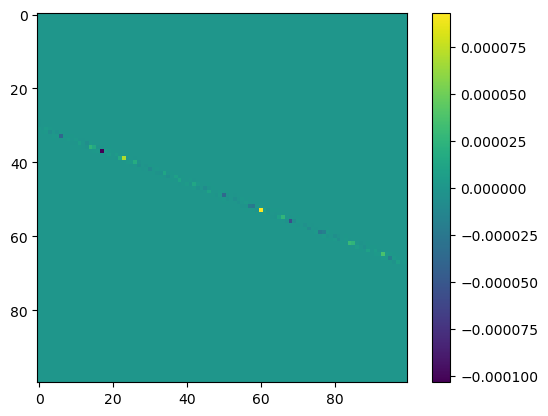

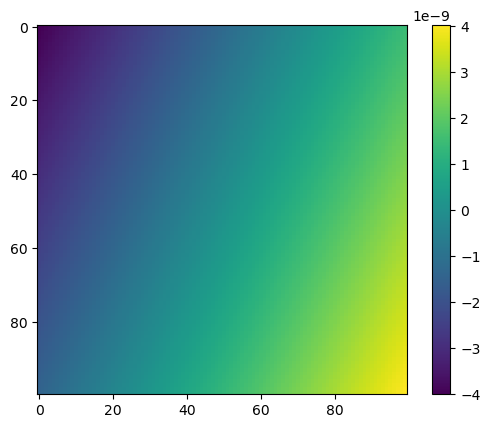

In [15]:
hypothesis_value = 3.40229174e-06
x = np.linspace(-0.01, 0.01, 100)
y = np.linspace(-0.01, 0.01, 100)
residual_okada = np.array(
    [
        [
            demonstrate_glitch("okada", delta_lon=x0, delta_lat=y0) - hypothesis_value
            for x0 in x
        ]
        for y0 in tqdm(y)
    ]
)
residual_cutde = np.array(
    [
        [
            demonstrate_glitch("cutde", delta_lon=x0, delta_lat=y0) - hypothesis_value
            for x0 in x
        ]
        for y0 in tqdm(y)
    ]
)

# Plot rasters of each residual
plt.imshow(residual_okada, cmap="viridis")
plt.colorbar()
plt.show()

plt.imshow(residual_cutde, cmap="viridis")
plt.colorbar()
